In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from analysis.heatmap_analysis import generate_heatmap
from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
)
import pdb





2023-03-14 12:15:35.094613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 12:15:59.115249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train/Load MDM2 vs. 12ca5 Model



In [161]:
import itertools
from functools import partial

protein_of_interest = "MDM2"
other_protein = "12ca5"

er_lib = data_loading.read_data_and_preprocess(
    datafile=f"{protein_of_interest}_merged_ER.csv"
)
fc_pval_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
joint_lib = er_lib.merge(
    right=fc_pval_lib, right_on="Peptide", left_on="Peptide", suffixes=("x", "")
)
X, y_raw, peptides = data_loading.build_joint_dataset(
    joint_lib, protein_of_interest=protein_of_interest, other_protein=other_protein
)

grid_search_params = {
    "param_power": [4.5, 5, 5.5, 6, 6.5, 7, 8],
    "weight_decay": [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2],
}

keys, values = zip(*grid_search_params.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

for permutation in permutations_dicts:
    (
        (
            mdm2_X_train,
            mdm2_X_test,
            mdm2_y_train,
            mdm2_y_test,
            mdm2_peptides_train,
            mdm2_peptides_test,
        ),
        mdm2_results,
    ) = experiment.Experiment().run_adhoc_experiment(
        X,
        y_raw,
        partial(
            rnn.ThreeChannelRegressionRNN_gelu, param_power=permutation["param_power"]
        ),
        optimizer=keras.optimizers.Adam(
            learning_rate=0.001, weight_decay=permutation["weight_decay"]
        ),
        load_trained_model=False,
        model_save_name=f"grid_search_models/mdm2_three_channel_GCV_parampower({permutation['param_power']})_weightdecay({permutation['weight_decay']}).h5",
        other_datasets=[
            peptides,
        ],
        normalize=True,
    )
    mdm2_model = mdm2_results.trained_model
    mdm2_pred = mdm2_model(X)
    mdm2_ordering = []
    for pred in mdm2_pred.numpy():
        mdm2_ordering.append(pred[0] + pred[1] + pred[2])

    plot_ratio_by_ranking(
        peptides=peptides,  # mdm2_peptides_test,
        ca5_y_ranking=None,
        mdm2_y_ranking=mdm2_ordering,  # np.squeeze(mdm2_only_er_results.y_pred), #mdm2_ordering,
        title="Hit Rates Against Enrichment Ratio BiLSTM Rankings \n(On Same Held Out Test Set)",
        plot_theoretical_maximums=True,
    )


/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/preprocessing/y_representation.py:67: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib[[protein_of_interest + idx for idx in REPLICATE_IDXS]].T,


64
4
we are here!
Epoch 1/20
206/206 [==============================] - 51s 240ms/step - loss: 0.8451 - multi_channel_mse: 0.8451 - fold_rmse: 0.8217 - p_value_rmse: 0.8136 - er_rmse: 0.9002 - lr: 0.0010
Epoch 2/20
206/206 [==============================] - 47s 230ms/step - loss: 0.7415 - multi_channel_mse: 0.7415 - fold_rmse: 0.7134 - p_value_rmse: 0.7002 - er_rmse: 0.8106 - lr: 0.0010
Epoch 3/20
206/206 [==============================] - 49s 240ms/step - loss: 0.7236 - multi_channel_mse: 0.7236 - fold_rmse: 0.6957 - p_value_rmse: 0.6817 - er_rmse: 0.7937 - lr: 0.0010
Epoch 4/20
206/206 [==============================] - 53s 258ms/step - loss: 0.7070 - multi_channel_mse: 0.7070 - fold_rmse: 0.6750 - p_value_rmse: 0.6694 - er_rmse: 0.7762 - lr: 0.0010
Epoch 5/20
206/206 [==============================] - 47s 228ms/step - loss: 0.7006 - multi_channel_mse: 0.7006 - fold_rmse: 0.6678 - p_value_rmse: 0.6649 - er_rmse: 0.7690 - lr: 0.0010
Epoch 6/20
206/206 [==============================] 

KeyboardInterrupt: 

In [153]:
mdm2_model.count_params()


289267

MDM2 area under curve:  299.13896065607565
normalized MDM2 area under curve:  0.5982779213121513


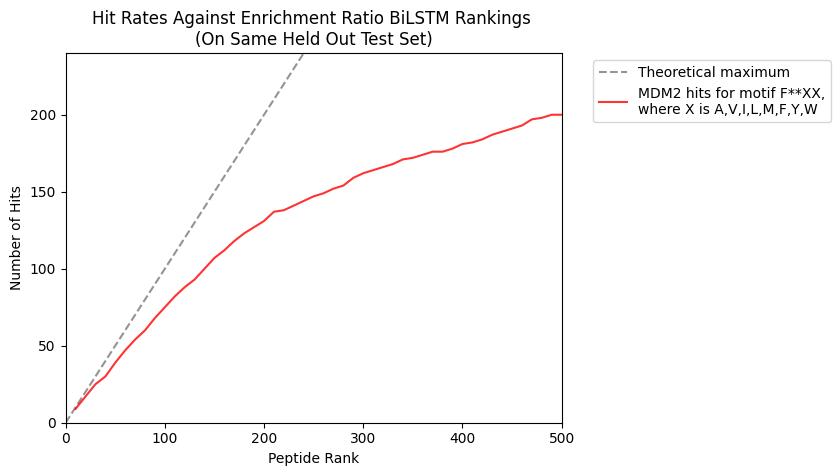

In [154]:
mdm2_model = mdm2_results.trained_model
mdm2_pred = mdm2_model(X)
mdm2_ordering = []
for pred in mdm2_pred.numpy():
    mdm2_ordering.append(pred[2] + pred[0] + pred[1])

plot_ratio_by_ranking(
    peptides=peptides,#mdm2_peptides_test,
    ca5_y_ranking=None,
    mdm2_y_ranking=mdm2_ordering,#np.squeeze(mdm2_only_er_results.y_pred), #mdm2_ordering,
    title="Hit Rates Against Enrichment Ratio BiLSTM Rankings \n(On Same Held Out Test Set)",
    plot_theoretical_maximums=True,
)


# Parity plots look poor

Text(0.5, 1.0, 'True versus Pred ER')

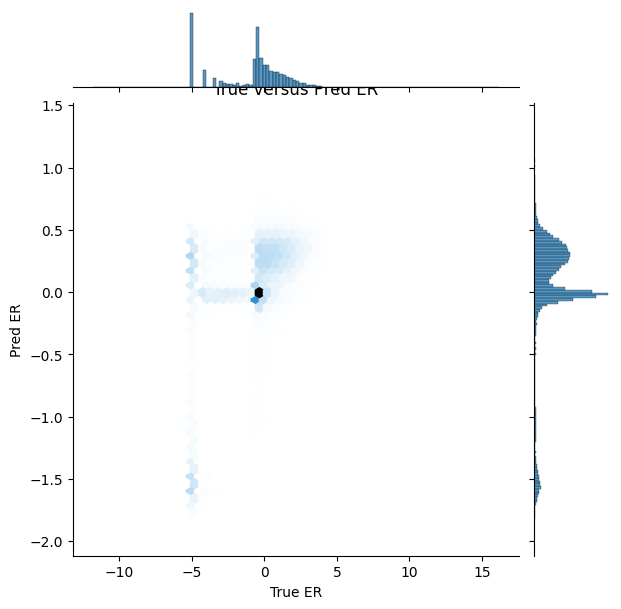

In [118]:
import seaborn as sns
# sns.jointplot(x=mdm2_y_test[:, 1], y=mdm2_y_test[:, 2],kind='hex')
sns.jointplot(x=y_raw[:, 2], y=mdm2_pred[:, 2], kind='hex')
plt.xlabel('True ER')
plt.ylabel('Pred ER')
plt.title('True versus Pred ER')

In [145]:
mdm2_pred.numpy()[:10].mean(axis=0)

array([ 1.7399477, -2.2825458, -1.7102616], dtype=float32)

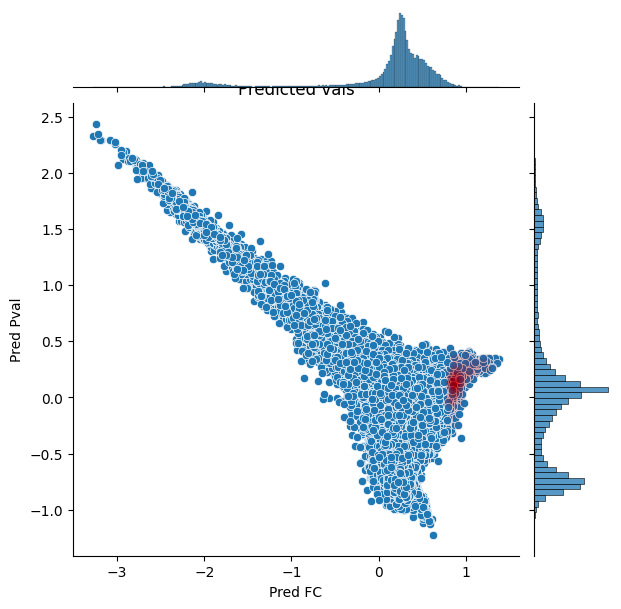

In [155]:
import seaborn as sns

def plot_relations(x_idx, y_idx, mdm2_ordering, mdm2_pred=mdm2_pred, vals=['Pval','FC', 'ER']):
    sns.jointplot(x=mdm2_pred[:, x_idx], y=mdm2_pred[:, y_idx]) # , kind='hex'
    plt.xlabel('Pred ' + vals[x_idx])
    plt.ylabel('Pred '+ vals[y_idx])
    plt.title('Predicted vals')

    top_mdm2_mask = mdm2_ordering >= np.partition(mdm2_ordering, kth=-500)[-500]
    plt.scatter(
        x=mdm2_pred[:, x_idx][top_mdm2_mask],
        y=mdm2_pred[:, y_idx][top_mdm2_mask],
        color="red",
        alpha=0.01,
    )

mdm2_ordering = []
for pred in mdm2_pred.numpy():
    mdm2_ordering.append(pred[2]) # pred[0] + pred[1] + 
plot_relations(1, 0, mdm2_ordering=mdm2_ordering)

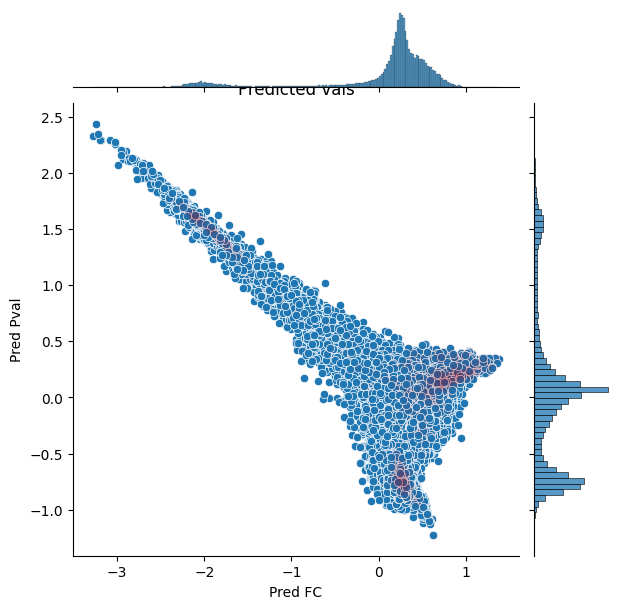

In [156]:

from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
    seq_contains_mdm2_motif,
)

# this is just the hypothetical best ordering
hypothetical_best_mdm2_ordering = np.array([ 1.0 if seq_contains_mdm2_motif(pep) else 0.0 for pep in peptides])
plot_relations(1, 0, mdm2_ordering=hypothetical_best_mdm2_ordering)

/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/preprocessing/y_representation.py:67: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib[[protein_of_interest + idx for idx in REPLICATE_IDXS]].T,


(32944, 14, 37)
MDM2 area under curve:  387.53298069246785
normalized MDM2 area under curve:  0.7750659613849357


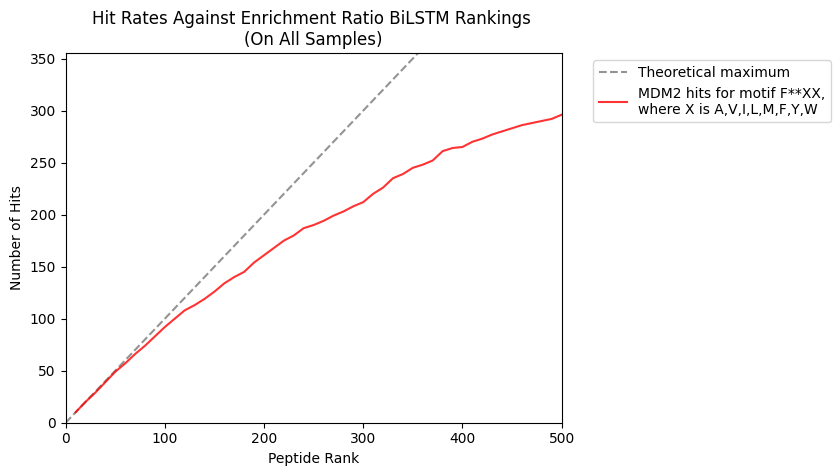

In [127]:
protein_of_interest = "MDM2"
other_protein = "12ca5"

er_lib = data_loading.read_data_and_preprocess(
    datafile=f"{protein_of_interest}_merged_ER.csv"
)
fc_pval_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
joint_lib = er_lib.merge(
    right=fc_pval_lib, right_on="Peptide", left_on="Peptide", suffixes=("x", "")
)
X, y_raw, peptides = data_loading.build_joint_dataset(
    joint_lib, protein_of_interest=protein_of_interest, other_protein=other_protein
)
(
    (
        mdm2_X_train,
        mdm2_X_test,
        mdm2_y_er_train,
        mdm2_y_er_test,
        mdm2_peptides_train,
        mdm2_peptides_test,
    ),
    mdm2_only_er_results,
) = experiment.Experiment().run_adhoc_experiment(
    X,
    y_raw[:, 2].reshape(-1,1),
    rnn.SingleRegressionRNN_gelu, #rnn.SingleChannelRegressionRNN, #rnn.ThreeChannelRegressionRNN,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    load_trained_model=True,
    model_save_name="mdm_2_ER_only_with_no_cadherin_data_2.h5",#'mdm_2_ER_3.h5',
    other_datasets=[
        peptides,
    ],
    normalize=True
)
mdm2_er_model = mdm2_only_er_results.trained_model
only_er_volcano_mdm2_ordering = np.squeeze([pred_val for pred_val in mdm2_er_model(X)])
print(X.shape)
mdm2_ordering = only_er_volcano_mdm2_ordering

plot_ratio_by_ranking(
    peptides=peptides,#mdm2_peptides_test,
    ca5_y_ranking=None,
    mdm2_y_ranking=mdm2_ordering,#np.squeeze(mdm2_only_er_results.y_pred), #mdm2_ordering,
    title="Hit Rates Against Enrichment Ratio BiLSTM Rankings \n(On All Samples)",
    plot_theoretical_maximums=True,
)


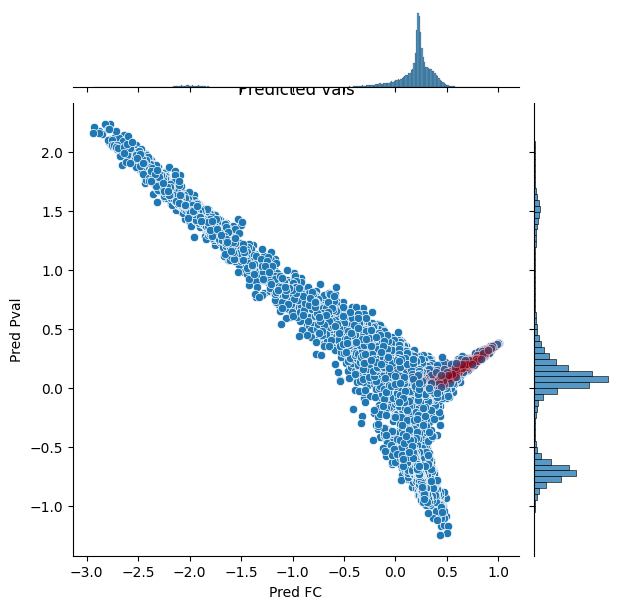

In [142]:

from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
    seq_contains_mdm2_motif,
)

# this is just the hypothetical best ordering
hypothetical_best_mdm2_ordering = np.array([ 1.0 if seq_contains_mdm2_motif(pep) else 0.0 for pep in peptides])
plot_relations(1, 0, mdm2_ordering=np.squeeze(mdm2_er_model(X).numpy()))